In [23]:
from heeps.config.read_config import read_config
from heeps.config.update_config import update_config
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img
from heeps.pupil.create_pupil import create_pupil
import numpy as np
import os
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

# Input parameters

In [24]:
pupil_img_size = 39.9988
diam_nominal = 38.542
diam_ext_M1 = 37.812        # average M1
diam_int_M1 = 10.196
diam_ext_AG = 36.905        # all-glass
diam_int_AG = 11.213
spi_width = 0.54
seg_width = 1.45
ravc_r_opt = 0.505          # cf. ravc optimisation
ravc_t_opt = 0.745
ls_misalign_x = 0.01
ls_misalign_y = 0
npupil = 1385
npupil_L = update_config(**dict(read_config(), band='L'))['npupil']
npupil_N = update_config(**dict(read_config(), band='N2'))['npupil']
print('npupil=%s, npupil_L=%s, npupil_N=%s'%(npupil, npupil_L, npupil_N))

npupil=1385, npupil_L=285, npupil_N=119


# Define functions to create Lyot stops

In [25]:
def create_ls(d_ext, d_int, ls_dRext, ls_dRint, ls_dRspi, circ_ext=True,
    circ_int=True):
    # 1% misalignments
    dx = ls_misalign_x*diam_nominal/pupil_img_size
    dy = ls_misalign_y*diam_nominal/pupil_img_size
    # create spider stop
    conf = dict(
        npupil=npupil,
        pupil_img_size=pupil_img_size, 
        diam_ext=2*pupil_img_size,  # no circular aperture
        diam_int=0,                 # no central obscuration
        seg_width=0,                # no segments
        spi_width=spi_width + ls_dRspi*diam_nominal,
    )
    mask_spi = create_pupil(dx=dx, dy=dy, **conf)
    # create outer and inner stops
    r_ext = (d_ext - ls_dRext*diam_nominal) / pupil_img_size
    r_int = (d_int + ls_dRint*diam_nominal) / pupil_img_size
    # create mask
    r, t = polar_coord(npupil, dx=dx, dy=dy)
    mask_ext = (r < r_ext) if circ_ext == True \
                         else ~dodecagon(r_ext, npupil, dx=dx, dy=dy)
    mask_int = (r > r_int) if circ_int == True \
                         else ~hexagon(r_int, npupil, dx=dx, dy=dy)
    # lyot stop
    return mask_spi * mask_ext * mask_int
def dodecagon(r_ext, nimg, dx=0, dy=0):
    x, y = cart_coord(nimg, dx=dx, dy=dy)
    M1 = mask_angle(x, y, r_ext, 0 , 90)
    M2 = mask_angle(x, y, r_ext, 30, 90)
    M3 = mask_angle(x, y, r_ext, 60, 90)
    M4 = mask_angle(x, y, r_ext, 90, 90)
    return M1 + M2 + M3 + M4
def hexagon(r_int, nimg, dx=0, dy=0):
    x, y = cart_coord(nimg, dx=dx, dy=dy)
    M5 = mask_angle(x, y, r_int, 30, 60)
    M6 = mask_angle(x, y, r_int, 30, 120)
    return ~(M5 + M6)
def mask_angle(x, y, r, theta, rot):
    P = (r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta)))
    a = np.tan(np.deg2rad(theta - rot))
    b = P[1] - a*P[0]
    mask = (y > a*x + b) + (y > -a*x + b) + (y < a*x - b) + (y < -a*x - b)
    return mask

# Check allglass vs fullM1

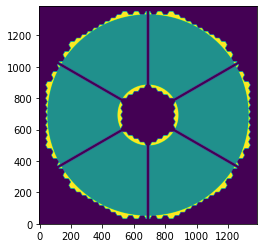

In [26]:
os.chdir(os.path.normpath(os.path.expandvars('$HOME/heeps_metis/input_files/pupil')))
try:
    mask_AG = fits.getdata('mask_AG.fits')
except FileNotFoundError:
    mask_AG = resize_img(fits.getdata('eso/mask_allglass.fits')
                       * fits.getdata('eso/SpiderShadow.fits'), npupil)
    fits.writeto('mask_AG.fits', mask_AG)
try:
    mask_M1 = fits.getdata('mask_M1.fits')
except FileNotFoundError:
    mask_M1 = resize_img(fits.getdata('eso/mask_fullM1.fits')
                       * fits.getdata('eso/SpiderShadow.fits'), npupil)
    fits.writeto('mask_M1.fits', mask_M1)
plt.imshow(mask_M1 - mask_AG/2, origin='lower');

diam_dodecagon = 36.8765
diam_hexagon = 11.6081


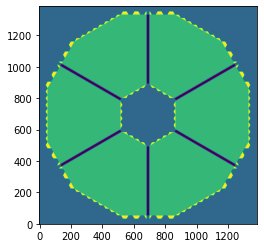

In [27]:
# a bit of geometry to find the dodecagon and hexagon edges ...
alpha = np.arcsin(seg_width/diam_ext_AG)
ds = seg_width*np.sin(np.pi/3)
dc = seg_width*np.cos(np.pi/3)
beta = np.arcsin(dc/diam_int_AG)
h = np.cos(beta)*diam_int_AG
diam_dodecagon = np.cos(alpha)*diam_ext_AG
diam_hexagon = h - ds + seg_width/np.cos(np.pi/6)
print('diam_dodecagon = %s\ndiam_hexagon = %s'%(np.round(diam_dodecagon, 4), 
    np.round(diam_hexagon, 4)))
r_ext = diam_dodecagon/pupil_img_size
r_int = diam_hexagon/pupil_img_size
mask = dodecagon(r_ext, npupil) + hexagon(r_int, npupil)
plt.imshow(mask_M1 + mask/2, origin='lower');

# L-band RAVC
### Calculate RAVC parameters (wrt all-glass diameters)

In [28]:
# all-glass parameters
r_obstr_AG = diam_int_AG/diam_ext_AG
ravc_t_AG = 1 - (r_obstr_AG**2 + r_obstr_AG*np.sqrt(r_obstr_AG**2 + 8))/4
ravc_r_AG = r_obstr_AG/np.sqrt(1 - ravc_t_AG)
diam_ravc_AG = ravc_r_AG*diam_ext_AG
print('diam_ravc_AG = %s (t=%s, r=%s)'%(np.round(diam_ravc_AG, 4),
    np.round(ravc_t_AG, 2), np.round(ravc_r_AG, 2)))
# full-M1 parameters
r_obstr_M1 = diam_int_M1/diam_ext_M1
ravc_t_M1 = 1 - (r_obstr_M1**2 + r_obstr_M1*np.sqrt(r_obstr_M1**2 + 8))/4
ravc_r_M1 = r_obstr_M1/np.sqrt(1 - ravc_t_M1) * (diam_ext_M1/diam_ext_AG)
diam_ravc_M1 = ravc_r_M1*diam_ext_AG
print('diam_ravc_M1 = %s (t=%s, r=%s)'%(np.round(diam_ravc_M1, 4),
    np.round(ravc_t_M1, 2), np.round(ravc_r_M1, 2)))
# optimal parameters (cf. ravc optimisation)
diam_ravc_opt = ravc_r_opt*diam_ext_AG
print('diam_ravc_opt = %s (t=%s, r=%s)'%(np.round(diam_ravc_opt, 4), 
    np.round(ravc_t_opt, 3), np.round(ravc_r_opt, 3)))

diam_ravc_AG = 22.9287 (t=0.76, r=0.62)
diam_ravc_M1 = 22.2647 (t=0.79, r=0.6)
diam_ravc_opt = 18.637 (t=0.745, r=0.505)


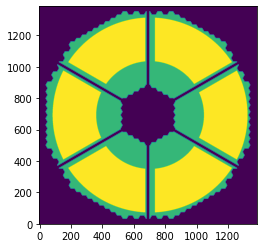

In [29]:
ls_params = (0.0291, 0.0291, 0.0317)
mask = create_ls(diam_ext_AG, diam_ravc_opt, *ls_params)
fits.writeto('ls_L_RAVC_%s_%s_%s_%s.fits'%(*ls_params, npupil_L), 
    resize_img(mask, npupil_L), overwrite=True)
plt.imshow(mask_M1 + mask/2, origin='lower');

# L-band CVC

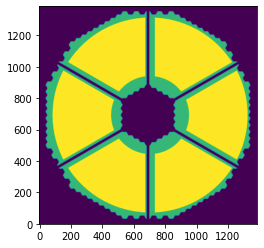

In [30]:
ls_params = (0.0291, 0.08, 0.0317)
mask = create_ls(diam_ext_AG, diam_int_AG, *ls_params)
fits.writeto('ls_L_CVC_%s_%s_%s_%s.fits'%(*ls_params, npupil_L), 
    resize_img(mask, npupil_L), overwrite=True)
plt.imshow(mask_M1 + mask/2, origin='lower');

# N2-band CVC

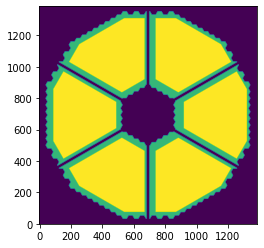

In [31]:
ls_params = (0.0356, 0.08, 0.0383)
mask = create_ls(diam_ext_AG, diam_int_AG, *ls_params)
fits.writeto('ls_N2_CVC_%s_%s_%s_%s_circ.fits'%(*ls_params, npupil_N), 
    resize_img(mask, npupil_N), overwrite=True)
mask = create_ls(diam_ext_AG, diam_int_AG, *ls_params, circ_ext=False, circ_int=False)
fits.writeto('ls_N2_CVC_%s_%s_%s_%s.fits'%(*ls_params, npupil_N), 
    resize_img(mask, npupil_N), overwrite=True)
plt.imshow(mask_M1 + mask/2, origin='lower');

# L-band CLC

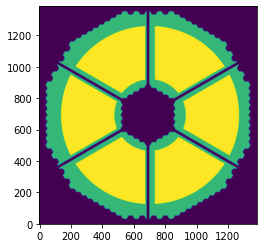

In [32]:
# values from Muskan wrt diam_nominal
ls_dRext = np.round(diam_ext_AG/diam_nominal - 0.848, 4)
ls_dRint = np.round(0.34 - diam_int_AG/diam_nominal, 4)
ls_params = (ls_dRext, ls_dRint, 0.0317)
mask = create_ls(diam_ext_AG, diam_int_AG, *ls_params)
fits.writeto('ls_L_CLC_%s_%s_%s_%s.fits'%(*ls_params, npupil_L), 
    resize_img(mask, npupil_L), overwrite=True)
plt.imshow(mask_M1 + mask/2, origin='lower');

# N2-band CLC

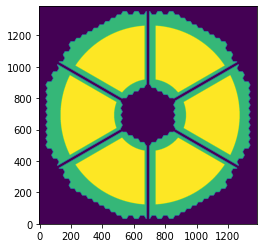

In [33]:
# values from Muskan wrt diam_nominal
ls_dRext = np.round(diam_ext_AG/diam_nominal - 0.853, 4)
ls_dRint = np.round(0.342 - diam_int_AG/diam_nominal, 4)
ls_params = (ls_dRext, ls_dRint, 0.0383)
mask = create_ls(diam_ext_AG, diam_int_AG, *ls_params)
fits.writeto('ls_N2_CLC_%s_%s_%s_%s.fits'%(*ls_params, npupil_N), 
    resize_img(mask, npupil_N), overwrite=True)
plt.imshow(mask_M1 + mask/2, origin='lower');